In [1]:
import zarr
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imsave
from cellpose import models

from skimage.measure import label
from skimage.segmentation import expand_labels

from typing import Tuple

2022-04-14 23:16:10,332 [INFO] WRITING LOG OUTPUT TO /home/ds/.cellpose/run.log


In [9]:
from findmycells import core

In [11]:
from findmycells.core import ProcessingObject

In [63]:
from abc import ABC, abstractmethod, abstractproperty

class Animal(ABC):
    
    def __init__(self, name: str):
        self.name = name
    
    @property
    @abstractproperty
    def animal_type(self):
        pass
    
    @property
    @abstractproperty
    def eat_meat(self):
        pass
    
    @property
    def self_report(self):
        return self.__class__.__name__
    

class Carnivores(Animal):
    
    @property
    def eat_meat(self):
        return True
    
    @abstractmethod
    def feed(self, food):
        pass

    
class Dog(Carnivores):
    
    def __init__(self, name):
        super().__init__(name = name)
        
    @property
    def animal_type(self):
        return 'hund'
    
    def feed(self, food):
        print(f'I ate {food}')

    def listed_second(self, a: int):
        return a*3
    
    def listed_first(self):
        print(self.listed_second(a = 3))
        


In [64]:
buddy = Dog(name='Buddy')

In [66]:
buddy.feed(food='gemüse')

I ate gemüse


In [8]:
empty_list = []
max(empty_list)

ValueError: max() arg is an empty sequence

In [4]:
snoopy = Dog(name='snoopy')

In [6]:
hasattr(snoopy, 'animal_type')

True

In [35]:
class TestObject(ProcessingObject):
    
    def __init__(self, database, file_ids, strategies, hund):
        super().__init__(database = database, file_ids = file_ids, strategies = strategies)
        self.hund = hund
        
    
    def update_database(self):
        print(self.database)

In [36]:
test_object = TestObject(database='database', file_ids = ['file_ids'], strategies = ['strategies'], hund = 'snoopy')

In [37]:
test_object.update_database()

database


In [ ]:

class SegmentationStrategy(ProcessingStrategy):
    
    @abstractmethod
    def run(self, segmentation_object: SegmentationObject, step: int) -> SegmentationObject:
        # do preprocessing
        segmentation_object.database = self.update_database(database = segmentation_object.database, file_id = segmentation_object.file_ids, step = step)
        return segmentation_object
    
    @abstractmethod
    def update_database(self, database: Database, file_ids: List[str], step: int) -> Database:
        for file_id in file_ids:
            updates = dict()
            updates[f'segmentation_step_{str(step).zfill(2)}'] = 'SegmentationStrategyName'
            # Add additional information if neccessary
            database.update_file_infos(file_id = file_id, updates = updates)
        return database

In [6]:
check = False

if check: 
    print('It´s true.')
elif not check:
    print('It´s false.')

It´s false.


In [5]:
def compute_cellpose_mask(df2_softmax: np.ndarray, diameter: int) -> np.ndarray:
    model = models.Cellpose(gpu=True, model_type='nuclei')
    cp_mask, _, _, _ = model.eval(df2_softmax, net_avg = True, augment = True, normalize=False, diameter = diameter, channels=[0,0])
    return cp_mask

def check_if_df2_pred_is_fully_covered_by_cp(df2_softmax: np.ndarray, cp_mask: np.ndarray) -> bool:
    cp_labels_within_df2_pred = np.unique(cp_mask[np.where(df2_softmax >= 0.5)])
    if 0 in cp_labels_within_df2_pred:
        warning = True
    else:
        warning = False
    return warning
    # to continue here:
    # if there is absolutely no cp label in a df2 ROI: fill it entirely with a new instance label (max current label + 1)
    # if there is a single cp label in a df2 ROI + some black pixels: fill entirely with respective cp label [check how large black pixels in comparison to ROI?]
    # if there are multiple cp labels in a df2 ROI + some black pixels: expand each individual label until entire df2 ROI is filled - HOW???
    
    
    


def check_if_df2_label_is_fully_covered_in_cp_mask(df2_pred: np.ndarray, df2_label_id: int, cp_mask: np.ndarray) -> bool:
    cp_labels_within_df2_label = np.unique(cp_mask[np.where(df2_pred == df2_label_id)])
    if 0 in cp_labels_within_df2_label:
        black_pixels_present = True
    else:
        black_pixels_present = False
    return black_pixels_present


def fill_entire_df2_label_area_with_instance_label(df2_pred: np.ndarray, df2_label_id: int, cp_mask: np.ndarray, converted_mask: np.ndarray) -> np.ndarray:
    cp_labels_within_df2_label = list(np.unique(cp_mask[np.where(df2_pred == df2_label_id)]))
    cp_labels_within_df2_label.remove(0)
    if len(cp_labels_within_df2_label) > 0:
        expanded_cp_mask = cp_mask.copy()
        expanded_cp_mask[np.where(df2_pred != df2_label_id)] = 0
        black_pixels_present, expansion_distance = True, 0
        while black_pixels_present:
            expansion_distance += 500
            expanded_cp_mask = expand_labels(expanded_cp_mask, distance = expansion_distance)
            black_pixels_present = check_if_df2_label_is_fully_covered_in_cp_mask(df2_pred = df2_pred,
                                                                                  df2_label_id = df2_label_id,
                                                                                  cp_mask = expanded_cp_mask)
        # remove all overflow pixels
        expanded_cp_mask[np.where(df2_pred != df2_label_id)] = 0
        for cp_label_id in cp_labels_within_df2_label:
            next_label_id = converted_mask.max() + 1
            converted_mask[np.where(expanded_cp_mask == cp_label_id)] = next_label_id
    else:
        next_label_id = converted_mask.max() + 1
        converted_mask[np.where(df2_pred == df2_label_id)] = next_label_id        
    return converted_mask
    

    
def lossless_conversion_of_df2_semantic_to_instance_seg_using_cp(df2_pred: np.ndarray, cp_mask: np.ndarray) -> np.ndarray:
    lossless_converted_mask = np.zeros_like(df2_pred)
    labeled_df2_pred = label(df2_pred)
    unique_df2_labels = list(np.unique(labeled_df2_pred))
    unique_df2_labels.remove(0)
    for original_df2_label in unique_df2_labels:
        black_pixels_present = check_if_df2_label_is_fully_covered_in_cp_mask(df2_pred = labeled_df2_pred,
                                                                              df2_label_id = original_df2_label,
                                                                              cp_mask = cp_mask)                                                        
        if black_pixels_present:
            lossless_converted_mask = fill_entire_df2_label_area_with_instance_label(df2_pred = labeled_df2_pred, 
                                                                                     df2_label_id = original_df2_label, 
                                                                                     cp_mask = cp_mask,
                                                                                     converted_mask = lossless_converted_mask)
        else:
            cp_labels_within_df2_label = np.unique(cp_mask[np.where(labeled_df2_pred == original_df2_label)])
            tmp_cp_mask = cp_mask.copy()
            tmp_cp_mask[np.where(labeled_df2_pred != original_df2_label)] = 0
            for cp_label_id in cp_labels_within_df2_label:
                next_label_id = lossless_converted_mask.max() + 1
                lossless_converted_mask[np.where(tmp_cp_mask == cp_label_id)] = next_label_id
    return lossless_converted_mask
        
                

In [8]:
max([0, 1, 2])

2

In [6]:
zarr_group = zarr.open('/mnt/c/Users/dsege/TEMP/findmycells_projects/temp2/', mode='r')

In [7]:
for elem in zarr_group['/smx'].__iter__():
    print(f'Starting with {elem}')
    cp_mask = compute_cellpose_mask(df2_softmax = zarr_group[f'/smx/{elem}'][..., 1], diameter = 50)
    df2_pred = np.zeros_like(zarr_group[f'/smx/{elem}'][..., 1])
    df2_pred[np.where(zarr_group[f'/smx/{elem}'][..., 1] >= 0.5)] = 1
    instance_mask = lossless_conversion_of_df2_semantic_to_instance_seg_using_cp(df2_pred = df2_pred, cp_mask = cp_mask)
    instance_mask = instance_mask.astype('uint16')
    imsave(f'/mnt/c/Users/dsege/TEMP/findmycells_projects/decouple_df2_and_cp/lossless_test_{elem}', instance_mask, check_contrast=False)

Starting with 0000-000.png
2022-04-14 23:23:31,649 [INFO] ** TORCH CUDA version installed and working. **
2022-04-14 23:23:31,650 [INFO] >>>> using GPU
2022-04-14 23:23:31,800 [INFO] ~~~ FINDING MASKS ~~~
2022-04-14 23:23:49,689 [INFO] >>>> TOTAL TIME 17.89 sec
Starting with 0000-001.png
2022-04-14 23:23:58,073 [INFO] ** TORCH CUDA version installed and working. **
2022-04-14 23:23:58,074 [INFO] >>>> using GPU
2022-04-14 23:23:58,274 [INFO] ~~~ FINDING MASKS ~~~
2022-04-14 23:24:15,327 [INFO] >>>> TOTAL TIME 17.05 sec
Starting with 0000-002.png
2022-04-14 23:24:50,116 [INFO] ** TORCH CUDA version installed and working. **
2022-04-14 23:24:50,117 [INFO] >>>> using GPU
2022-04-14 23:24:50,243 [INFO] ~~~ FINDING MASKS ~~~
2022-04-14 23:25:08,204 [INFO] >>>> TOTAL TIME 17.96 sec
Starting with 0000-003.png
2022-04-14 23:27:30,204 [INFO] ** TORCH CUDA version installed and working. **
2022-04-14 23:27:30,204 [INFO] >>>> using GPU
2022-04-14 23:27:30,303 [INFO] ~~~ FINDING MASKS ~~~
2022-04-1

KeyboardInterrupt: 

In [5]:
type(instance_mask)

numpy.ndarray

In [6]:
instance_mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [7]:
np.unique(instance_mask)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47.], dtype=float32)

In [13]:
conv = instance_mask.astype('uint16')

In [14]:
np.unique(conv)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
      dtype=uint16)

In [10]:
type(zarr_group[f'/smx/{elem}'][..., 1])

numpy.ndarray

In [78]:
df2_pred = imread('/mnt/c/Users/dsege/TEMP/findmycells_projects/dummy_data/dummy_df2.png')
cp_mask = imread('/mnt/c/Users/dsege/TEMP/findmycells_projects/dummy_data/dummy_cp.png')
cp_mask2 = imread('/mnt/c/Users/dsege/TEMP/findmycells_projects/dummy_data/dummy_cp_single_label.png')
cp_mask3 = imread('/mnt/c/Users/dsege/TEMP/findmycells_projects/dummy_data/dummy_cp_no_label.png')

In [82]:
df2_multi_pred = imread('/mnt/c/Users/dsege/TEMP/findmycells_projects/dummy_data/dummy_df2_multi.png')
cp_multi_mask = imread('/mnt/c/Users/dsege/TEMP/findmycells_projects/dummy_data/dummy_cp_multi.png')

In [55]:
test = np.unique(cp_mask[np.where(df2_pred >= 128)])

In [61]:
test

array([  0, 165, 232], dtype=uint8)

In [45]:
test.remove(0.0)

In [54]:
test2 = [0, 27]
test2.remove(0)
len(test2) > 0

True

In [87]:
from skimage.measure import label
from skimage.segmentation import expand_labels

from typing import Tuple

def check_if_df2_label_is_fully_covered_in_cp_mask(df2_pred: np.ndarray, df2_label_id: int, cp_mask: np.ndarray) -> bool:
    cp_labels_within_df2_label = np.unique(cp_mask[np.where(df2_pred == df2_label_id)])
    if 0 in cp_labels_within_df2_label:
        black_pixels_present = True
    else:
        black_pixels_present = False
    return black_pixels_present


def fill_entire_df2_label_area_with_instance_label(df2_pred: np.ndarray, df2_label_id: int, cp_mask: np.ndarray, converted_mask: np.ndarray) -> np.ndarray:
    cp_labels_within_df2_label = list(np.unique(cp_mask[np.where(df2_pred == df2_label_id)]))
    cp_labels_within_df2_label.remove(0)
    if len(cp_labels_within_df2_label) > 0:
        expanded_cp_mask = cp_mask.copy()
        expanded_cp_mask[np.where(df2_pred != df2_label_id)] = 0
        black_pixels_present, expansion_distance = True, 0
        while black_pixels_present:
            expansion_distance += 500
            expanded_cp_mask = expand_labels(expanded_cp_mask, distance = expansion_distance)
            black_pixels_present = check_if_df2_label_is_fully_covered_in_cp_mask(df2_pred = df2_pred,
                                                                                  df2_label_id = df2_label_id,
                                                                                  cp_mask = expanded_cp_mask)
        # remove all overflow pixels
        expanded_cp_mask[np.where(df2_pred != df2_label_id)] = 0
        for cp_label_id in cp_labels_within_df2_label:
            next_label_id = converted_mask.max() + 1
            converted_mask[np.where(expanded_cp_mask == cp_label_id)] = next_label_id
    else:
        next_label_id = converted_mask.max() + 1
        converted_mask[np.where(df2_pred == df2_label_id)] = next_label_id        
    return converted_mask
    

    
def lossless_conversion_of_df2_semantic_to_instance_seg_using_cp(df2_pred: np.ndarray, cp_mask: np.ndarray) -> np.ndarray:
    lossless_converted_mask = np.zeros_like(df2_pred)
    labeled_df2_pred = label(df2_pred)
    unique_df2_labels = list(np.unique(labeled_df2_pred))
    unique_df2_labels.remove(0)
    for original_df2_label in unique_df2_labels:
        black_pixels_present = check_if_df2_label_is_fully_covered_in_cp_mask(df2_pred = labeled_df2_pred,
                                                                              df2_label_id = original_df2_label,
                                                                              cp_mask = cp_mask)                                                        
        if black_pixels_present:
            lossless_converted_mask = fill_entire_df2_label_area_with_instance_label(df2_pred = labeled_df2_pred, 
                                                                                     df2_label_id = original_df2_label, 
                                                                                     cp_mask = cp_mask,
                                                                                     converted_mask = lossless_converted_mask)
        else:
            cp_labels_within_df2_label = np.unique(cp_mask[np.where(labeled_df2_pred == original_df2_label)])
            tmp_cp_mask = cp_mask.copy()
            tmp_cp_mask[np.where(labeled_df2_pred != original_df2_label)] = 0
            for cp_label_id in cp_labels_within_df2_label:
                next_label_id = lossless_converted_mask.max() + 1
                lossless_converted_mask[np.where(tmp_cp_mask == cp_label_id)] = next_label_id
    return lossless_converted_mask
        
                

In [98]:
df2_pred = imread('/mnt/c/Users/dsege/TEMP/findmycells_projects/decouple_df2_and_cp/03b_semantic_segmentations/0000-004.png')
cp_mask = imread('/mnt/c/Users/dsege/TEMP/findmycells_projects/decouple_df2_and_cp/03c_instance_segmentations/0000-004.png_class1.tif')

In [99]:
instance_mask = lossless_conversion_of_df2_semantic_to_instance_seg_using_cp(df2_pred = df2_pred, cp_mask = cp_mask)
imsave('/mnt/c/Users/dsege/TEMP/findmycells_projects/decouple_df2_and_cp/lossless_test_004.png', instance_mask)

In [100]:
imsave('/mnt/c/Users/dsege/TEMP/findmycells_projects/decouple_df2_and_cp/lossless_test_004.png', instance_mask)

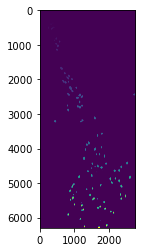

In [95]:
plt.imshow(instance_mask)

In [71]:
np.unique(instance_mask)

array([1, 2, 3], dtype=uint8)

In [ ]:
check = True

if not check:
    print('ja')

In [25]:
labeled_df2_pred = label(df2_pred)

In [27]:
labeled_df2_pred.max()

1

In [20]:
df2_cp_corrected = np.zeros_like(df2_pred)

In [23]:
df2_cp_corrected[np.where(df2_pred == 255)] = expanded[np.where(df2_pred == 255)]

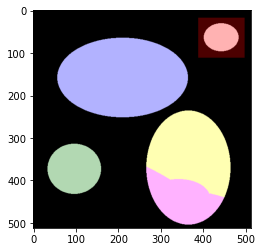

In [86]:
color3 = label2rgb(instance_mask, image=df2_multi_pred, bg_label=0)
plt.imshow(color3)

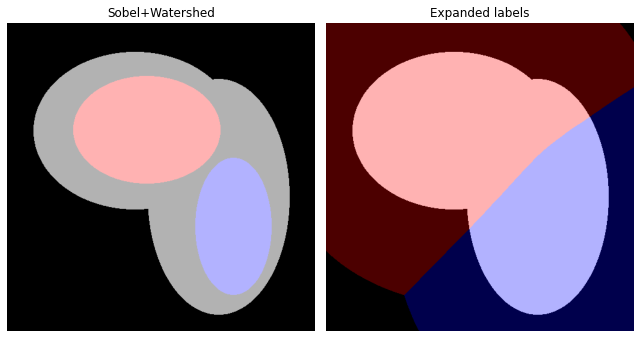

In [90]:
from skimage.segmentation import expand_labels
from skimage.color import label2rgb

expanded = expand_labels(cp_mask, 200)

# Show the segmentations.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5),
                         sharex=True, sharey=True)

color1 = label2rgb(cp_mask, image=df2_pred, bg_label=0)
axes[0].imshow(color1)
axes[0].set_title('Sobel+Watershed')

color2 = label2rgb(expanded, image=df2_pred, bg_label=0)
axes[1].imshow(color2)
axes[1].set_title('Expanded labels')

for a in axes:
    a.axis('off')
fig.tight_layout()
plt.show()

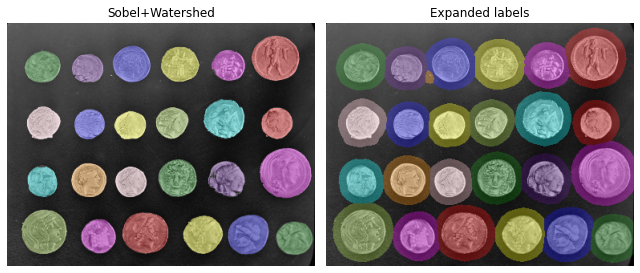

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import sobel
from skimage.measure import label
from skimage.segmentation import watershed, expand_labels
from skimage.color import label2rgb
from skimage import data

coins = data.coins()

# Make segmentation using edge-detection and watershed.
edges = sobel(coins)

# Identify some background and foreground pixels from the intensity values.
# These pixels are used as seeds for watershed.
markers = np.zeros_like(coins)
foreground, background = 1, 2
markers[coins < 30.0] = background
markers[coins > 150.0] = foreground

ws = watershed(edges, markers)
seg1 = label(ws == foreground)

expanded = expand_labels(seg1, distance=10)

# Show the segmentations.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5),
                         sharex=True, sharey=True)

color1 = label2rgb(seg1, image=coins, bg_label=0)
axes[0].imshow(color1)
axes[0].set_title('Sobel+Watershed')

color2 = label2rgb(expanded, image=coins, bg_label=0)
axes[1].imshow(color2)
axes[1].set_title('Expanded labels')

for a in axes:
    a.axis('off')
fig.tight_layout()
plt.show()

In [10]:
np.unique(seg1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int32)

In [11]:
np.unique(expanded)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int32)

In [3]:
thresholded = zarr_group['smx/0000-000.png'][:, :, 1].copy()
#thresholded[np.where(thresholded < 0.5)] = 0

In [14]:
thresholded = thresholded * 255

In [15]:
thresholded = np.around(thresholded)

In [16]:
thresholded = thresholded.astype('uint8')

In [4]:
np.unique(thresholded)

array([3.5176657e-07, 3.5305533e-07, 3.5568971e-07, ..., 7.2623068e-01,
       7.2664142e-01, 7.2677177e-01], dtype=float32)

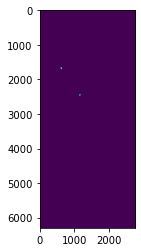

In [18]:
plt.imshow(thresholded)

In [19]:
imsave('/mnt/c/Users/dsege/TEMP/findmycells_projects/temp2/0000_000_thresholded_smx.png', thresholded)

/home/ds/anaconda3/envs/DCLwidgets_clone_cp/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: /mnt/c/Users/dsege/TEMP/findmycells_projects/temp2/0000_000_thresholded_smx.png is a low contrast image
  """Entry point for launching an IPython kernel.


In [17]:
smxs

[<LazyLoader: 0000-000.png, 0000-001.png, 0000-002.png, 0000-003.png, 0000-004.png, 0000-005.png, 0000-006.png, 0000-007.png>]

In [2]:
from pathlib import Path

all_softmaxes = Path('/mnt/c/Users/dsege/TEMP/findmycells_projects/temp2/smx/')

In [3]:
cl = 0
smxs, preds = [], []
for elem in all_softmaxes.iterdir():
    if elem.name.startswith('.') == False:
        if len(preds) < 1:
            softmax = zarr.load(elem)
            smxs.append(softmax)
            preds.append(np.argmax(softmax, axis=-1).astype('uint8'))

probs = [x[...,cl] for x in smxs]
masks = [x==cl for x in preds]

In [4]:
prob = probs[0]
mask = masks[0]

In [5]:
from cellpose import models, io

In [5]:
from cellpose import models, io
from cellpose import dynamics, utils
from fastcore.basics import patch
@patch
def _compute_masks(self:models.CellposeModel, dP, cellprob, p=None, niter=100,
                    flow_threshold=0.4, interp=True, do_3D=False, min_size=15, resize=None, **kwargs):
    """ compute masks using dynamics from dP and cellprob """
    if p is None:
        p = dynamics.follow_flows(-1 * dP * mask / 5., niter=niter, interp=interp, use_gpu=self.gpu)
    maski = dynamics.get_masks(p, iscell=mask, flows=dP, threshold=flow_threshold if not do_3D else None)
    maski = utils.fill_holes_and_remove_small_masks(maski, min_size=min_size)
    if resize is not None:
        maski = transforms.resize_image(maski, resize[0], resize[1],
                                        interpolation=cv2.INTER_NEAREST)
    return maski, p

2022-04-12 13:33:53,183 [INFO] WRITING LOG OUTPUT TO /home/ds/.cellpose/run.log


Run cellpose on softmax (directly loaded from Zarr without thresholding or saving as 8-bit, values will thus range from 0-1)
Important: pass pre-calculated 'diameter' as this seems to be the most critical factor to define a good/perfect overlap with df2 semantic predictions
Overlay df2 semantic segmentations with predicted cp mask to get instance segmentation mask

--> However, look out for:

- if pixels of the df2 segmentation are black (=0) in the cp mask --> cp instances need to be expanded in this case!

- for now, build something that logs it whenever a df2 prediction is not fully covered by a cp prediction!

In [6]:
model = models.Cellpose(gpu=False, model_type='nuclei')

In [21]:
img = io.imread('/mnt/c/Users/dsege/TEMP/findmycells_projects/temp2/0000_000_thresholded_smx.png')

In [31]:
cp_masks, flows, styles, diams = model.eval(thresholded, net_avg = False, augment = True, normalize=False, channels=[0,0])


In [34]:
diams

30.0

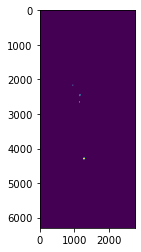

In [32]:
plt.imshow(cp_masks)

In [33]:
cp_masks.max()

4

In [30]:
imsave('/mnt/c/Users/dsege/TEMP/findmycells_projects/temp2/0000_000_cp4.png', cp_masks)

/home/ds/anaconda3/envs/DCLwidgets_clone_cp/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: /mnt/c/Users/dsege/TEMP/findmycells_projects/temp2/0000_000_cp4.png is a low contrast image
  """Entry point for launching an IPython kernel.


In [11]:
thresholded_cp_mask = cp_masks.copy()
thresholded_cp_mask[np.where(thresholded < 0.5)] = 0

In [14]:
np.unique(cp_masks[np.where(thresholded >= 0.5)])

array([0, 2], dtype=uint16)

In [15]:
np.unique(thresholded[np.where(cp_masks == 2)])

array([0.29122475, 0.29338548, 0.2986319 , ..., 0.7262307 , 0.7266414 ,
       0.7267718 ], dtype=float32)

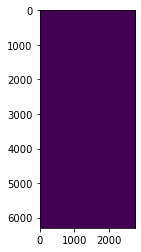

In [12]:
plt.imshow(thresholded_cp_mask)

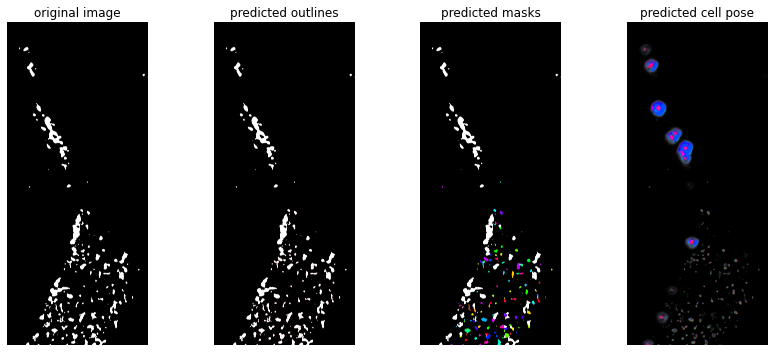

In [16]:
from cellpose import plot

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0], channels=channels)
plt.tight_layout()
plt.show()

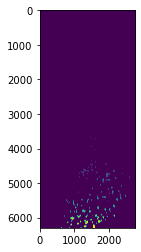

In [18]:
plt.imshow(masks)

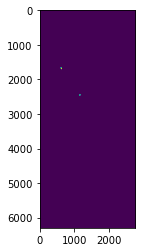

In [24]:
plt.imshow(thresholded)

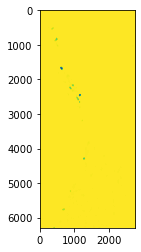

In [21]:
plt.imshow(zarr_group['smx/0000-000.png'][:, :, 0])